In [21]:
import requests
import pandas as pd
import selenium
import undetected_chromedriver as uc
from selenium.webdriver.common.by import By
import time
import random
import re
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# FUNCIONES

In [28]:
def accept_cookies(driver):
    """Función para aceptar cookies en la página web."""
    time.sleep(random.uniform(5, 10))  # Esperar a que la página cargue
    try:
        agree_button = driver.find_element(By.ID, "didomi-notice-agree-button")
        agree_button.click()
        print("Se hizo clic en el botón de aceptar cookies")
    except Exception as e:
        print(f"No se encontró el botón de aceptar cookies")
    time.sleep(random.uniform(0.5, 1))  # Esperar después de hacer clic



def extraer_info_descripcion(df):
    def detectar_motor(desc):
        desc = desc.lower()

        # 1. Buscar formatos con cc (ej: 2000 cc)
        match = re.search(r'(\d{4})\s?cc', desc)
        if match:
            cc = int(match.group(1))
            if 1000 <= cc <= 6000:
                return f"{cc/1000:.1f}"

        # 2. Buscar X.Xi, X.X i (ej: 2.8i, 2.0 i)
        match = re.search(r'\b(\d\.\d)\s?i\b', desc)
        if match:
            return match.group(1)

        # 3. Buscar "swap a 2.8"
        match = re.search(r'swap\s+a\s+(\d[\.,]?\d?)', desc)
        if match:
            return match.group(1).replace(',', '.')

        # 4. Buscar tipo “motor 1.8 gasolina” o “1.9 de 140cv”
        match = re.search(r'\bmotor\s+(\d[\.,]?\d?)', desc)
        if match:
            return match.group(1).replace(',', '.')

        match = re.search(r'\b(\d[\.,]\d)\s?(?:l|litros)?\b', desc)
        if match:
            return match.group(1).replace(',', '.')

        return None

    def detectar_modelo(desc):
        desc = desc.lower()
        if 'roadster' in desc or 'cabrio' in desc:
            return 'ROADSTER'
        elif 'coupe' in desc or 'coupé' in desc:
            return 'COUPE'
        elif 'cabrio' in desc:
            return 'CABRIO' 
        return None
    
    def detectar_cv(desc):
        desc = desc.lower()
        match = re.search(r'(\d{2,4})\s?cv', desc)
        if match:
            return int(match.group(1))
        return None

    # Extraer motor
    df['motor_from_desc'] = df['description'].apply(detectar_motor)
    df['cv_from_desc'] = df['description'].apply(detectar_cv)
    # Extraer tipo de carrocería
    df['carroceria_from_desc'] = df['description'].apply(detectar_modelo)

    # Combinar motor y carrocería en formato '2.0 ROADSTER'
    def construir_version(motor, carroceria):
        if pd.notna(motor) and pd.notna(carroceria):
            return f"{motor} {carroceria}".upper()
        elif pd.notna(motor):
            return str(motor).upper()
        elif pd.notna(carroceria):
            return str(carroceria).upper()
        return None

    df['version_from_desc'] = df.apply(
        lambda row: construir_version(row['motor_from_desc'], row['carroceria_from_desc']),
        axis=1
    )

    df.drop(columns=['carroceria_from_desc'], inplace=True)

    return df


def data_preprocessing(df, car):
    df = df.drop_duplicates()

    # Establecer marca y modelo fijos
    df['brand'] = 'BMW'
    df['model'] = car

    def extract_info(name):
        name = name.upper().strip()

        # Extraer lo que está después de "BMW Z3"
        prefix = f"BMW {car}".upper()
        version_raw = name.replace(prefix, '').strip()

        # Tokenizar por espacio
        tokens = version_raw.split()
        tokens = list(dict.fromkeys(tokens))  # eliminar duplicados conservando orden

        # Inicializar
        engine = None
        body = None
        extras = []

        # Procesar cada token
        for token in tokens:
            # Detectar motor: 1.8, 2.0, 2.8I, etc.
            if re.fullmatch(r'\d\.\dI?', token):
                if not engine:
                    engine = token.replace('I', '')  # 2.8I → 2.8
                continue

            # Carrocería
            if token in ['ROADSTER', 'COUPE', 'CABRIO']:
                if token == 'CABRIO':
                    body = 'ROADSTER'  # Normalizar
                else:
                    body = token
                continue

            # Otros: los tratamos como extras
            extras.append(token)

        # Construir versión
        version_parts = []
        if engine:
            version_parts.append(engine)
        if body:
            version_parts.append(body)
        if extras:
            version_parts.extend(extras)

        version_final = ' '.join(version_parts).strip()
        return pd.Series([engine, version_final if version_final else None])

    # Limpiar campos numéricos
    df['kms'] = df['kms'].str.replace('.', '', regex=False).str.extract(r'(\d+)').astype(float)
    df['cv'] = df['cv'].str.extract(r'(\d+)').astype(float)
    df['price'] = df['price'].str.replace('.', '', regex=False).str.extract(r'(\d+)').astype(float)

    # Aplicar extracción
    df[['engine', 'version']] = df['name'].apply(extract_info)

    return df

def actualizar_con_descripciones(df_main, df_extra):
    # Unir los dos DataFrames por 'url'
    merged = pd.merge(df_main, df_extra, on='url', how='left')

    # Actualizar columnas solo si en df_extra hay datos
    for col_main, col_extra in [
        ('engine', 'motor_from_desc'),
        ('cv', 'cv_from_desc'),
        # ('version', 'version_from_desc'),
    ]:
        merged[col_main] = merged[col_extra].combine_first(merged[col_main])

    # Eliminar columnas extra que no necesitas
    merged = merged[df_main.columns]
    merged['year'] = merged['year'].astype(int)
    merged['kms'] = merged['kms'].astype(float).astype(int)
    merged['cv'] = pd.to_numeric(merged['cv'], errors='coerce').astype('Int64')
    return merged



def regression_data_processing(df, engine_cc_filter, var='kms'):
    """
    Filtra y limpia datos, ajusta el modelo y añade columnas:
    predicted_price
    """
    filtered_df = df[df['engine'] == engine_cc_filter].copy()
    filtered_df = filtered_df.dropna(subset=[var])
    # Modelo regresión lineal
    X = filtered_df[[var]].values
    y = filtered_df['price'].values
    model = LinearRegression()
    model.fit(X, y)
    filtered_df['predicted_price'] = model.predict(X)

    return filtered_df, model

# Estrategias (reciben DataFrame con predicted_price ya calculado)

def strategy_discount_line(df, discount_factor=0.85):
    df = df.copy()
    df['discount_line'] = df['predicted_price'] * discount_factor
    return df['price'] < df['discount_line']

def strategy_residual_threshold(df, threshold_euros=1000):
    df = df.copy()
    df['residual'] = df['predicted_price'] - df['price']
    return df['residual'] > threshold_euros

def strategy_top_percentile_residuals(df, percentile=90):
    df = df.copy()
    df['residual'] = df['predicted_price'] - df['price']
    threshold = np.percentile(df['residual'], percentile)
    return df['residual'] > threshold

def strategy_residual_zscore(df, z_threshold=1.5):
    df = df.copy()
    df['residual'] = df['predicted_price'] - df['price']
    z_mean = df['residual'].mean()
    z_std = df['residual'].std()
    df['z_score'] = (df['residual'] - z_mean) / z_std
    return df['z_score'] > z_threshold

def plot_strategy_separately(df, model, var='kms', discount_factor=0.85, strategy_mask=None, strategy_name="Estrategia"):
    """
    Grafica los datos diferenciando con color rojo los coches que cumplen la estrategia dada.
    - df: DataFrame con columnas kms, price, predicted_price
    - model: modelo de regresión entrenado
    - discount_factor: para graficar la línea de descuento
    - strategy_mask: máscara booleana indicando coches que cumplen la estrategia
    - strategy_name: nombre para leyenda y título
    """
    X_range = np.linspace(df[var].min(), df[var].max(), 100).reshape(-1, 1)
    y_pred = model.predict(X_range)
    y_discount = y_pred * discount_factor

    plt.figure(figsize=(10,6))
    # Puntos que no cumplen la estrategia
    plt.scatter(df.loc[~strategy_mask, var], df.loc[~strategy_mask, 'price'],
                alpha=0.5, label='Datos')
    # Puntos que cumplen la estrategia
    plt.scatter(df.loc[strategy_mask, var], df.loc[strategy_mask, 'price'],
                color='red', label='Buena oferta')

    plt.plot(X_range, y_pred, color='blue', label='Regresión lineal')
    plt.plot(X_range, y_discount, color='green', linestyle='--',
             label=f'Oferta (~{int((1 - discount_factor)*100)}% menos)')

    plt.xlabel('Kilómetros')
    plt.ylabel('Precio (€)')
    plt.title(f'Relación Km vs Precio - {strategy_name}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# SCRAPPING COCHES.NET

In [23]:
url_dict = {
    "Z3": "https://www.coches.net/search/?MakeIds%5B0%5D=7&ModelIds%5B0%5D=282&Versions%5B0%5D=&fi=Price&or=1&pg=",
    "Z4": "https://www.coches.net/search/?MakeIds%5B0%5D=7&ModelIds%5B0%5D=291&Versions%5B0%5D=&fi=Price&or=1&pg=",
}
# base_url = "https://www.coches.net/search/?MakeIds%5B0%5D=7&ModelIds%5B0%5D=282&Versions%5B0%5D=&pg="
car = "Z3"  # Cambia a "Z4" si quieres buscar Z4
base_url = url_dict[car]  # Cambia a "Z4" si quieres buscar Z4

In [24]:
import undetected_chromedriver as uc
from selenium.webdriver.common.by import By
import time
import random


driver = uc.Chrome()  # options=options


df = pd.DataFrame(columns=["name", "price", "fuel_type", "year", "kms", "cv", "location", "url"])

page = 1  # Iniciar desde la página 1
while True:
    try:
        # Construir la URL de la página actual
        url = f"{base_url}{page}"
        driver.get(url)
        print(f"Cargando página {page}...")

        # Esperar a que la página cargue completamente
        time.sleep(random.uniform(5, 10))

        # Buscar el botón de aceptar cookies solo en la primera página
        if page == 1:
            try:
                agree_button = driver.find_element(By.ID, "didomi-notice-agree-button")
                agree_button.click()
                print("Se hizo clic en el botón de aceptar cookies")
            except Exception as e:
                print(f"No se encontró el botón de aceptar cookies: {e}")

        # Desplazar hasta el fondo de la página para cargar más contenido
        scroll_increment = 400
        last_height = driver.execute_script("return document.body.scrollHeight")
        current_position = 0
        while current_position < last_height:
            driver.execute_script(f"window.scrollTo(0, {current_position});")
            time.sleep(random.uniform(1.5, 2))
            current_position += scroll_increment
            last_height = driver.execute_script("return document.body.scrollHeight")
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(random.uniform(2, 5))

        # Obtener los anuncios de la página actual
        car_ads = driver.find_elements(By.CLASS_NAME, "mt-CardAd-infoContainer")
        if not car_ads:
            print("No se encontraron más anuncios. Finalizando...")
            break

        for add in car_ads:
            try:
                # Buscar los elementos dentro de cada anuncio
                name = add.find_element(By.CLASS_NAME, "mt-CardAd-infoHeaderTitleLink").text
                price = add.find_element(By.CLASS_NAME, "mt-CardAdPrice-cashAmount").text
                attributes = add.find_elements(By.CLASS_NAME, "mt-CardAd-attrItem")

                # Obtener todos los atributos de la lista
                # Inicializar valores
                fuel_type, year, kms, cv, location = "N/A", "N/A", "N/A", "N/A", "N/A"

                # Recorrer los atributos y asignar según contenido
                for attr in attributes:
                    text = attr.text.strip()

                    if text.lower() in ["gasolina", "diésel", "eléctrico", "híbrido", "hibrido", "glp", "gnc"]:
                        fuel_type = text
                    elif "km" in text.lower():
                        kms = text
                    elif "cv" in text.lower():
                        cv = text
                    elif text.isdigit() and len(text) == 4:
                        year = text
                    else:
                        location = text  # suele ir al final si no es otra cosa
                url = add.find_element(By.CLASS_NAME, "mt-CardAd-infoHeaderTitleLink").get_attribute("href")
                # Agregar los datos al DataFrame
                df = pd.concat([df, pd.DataFrame([{
                    "name": name,
                    "price": price,
                    "fuel_type": fuel_type,
                    "year": year,
                    "kms": kms,
                    "cv": cv,
                    "location": location,
                    "url": url,
                }])], ignore_index=True)
            except Exception as e:
                print(f"Error al procesar un anuncio: {e}")

        # Incrementar el número de página
        page += 1

    except Exception as e:
        print(f"Error al cargar la página {page}: {e}")
        break

# Cerrar el navegador
print("Cerrando el navegador")
driver.quit()

Cargando página 1...
Se hizo clic en el botón de aceptar cookies
Cargando página 2...
Cargando página 3...
Cargando página 4...
Cargando página 5...
No se encontraron más anuncios. Finalizando...
Cerrando el navegador


# SCRAPED DATA PREPROCESSING

In [29]:
df_test = data_preprocessing(df, car)
df_test

,name,price,fuel_type,year,kms,cv,location,url,brand,model,engine,version
0,BMW Z3,900.0,Gasolina,2000,167000.0,NaN,Barcelona,https://www.coches.net/bmw-z3-gasolina-2000-en...,BMW,Z3,None,None
1,BMW Z3,2150.0,Gasolina,1998,250000.0,NaN,Madrid,https://www.coches.net/bmw-z3-gasolina-1998-en...,BMW,Z3,None,None
2,BMW Z3,4800.0,Gasolina,1997,286200.0,NaN,Cádiz,https://www.coches.net/bmw-z3-gasolina-1997-en...,BMW,Z3,None,None
3,BMW Z3,4999.0,Gasolina,1996,191000.0,NaN,Las Palmas,https://www.coches.net/bmw-z3-gasolina-1996-en...,BMW,Z3,None,None
4,BMW Z3 1.8 ROADSTER,5000.0,Gasolina,2001,238000.0,118.0,Murcia,https://www.coches.net/bmw-z3-18-roadster-2p-g...,BMW,Z3,1.8,1.8 ROADSTER
...,...,...,...,...,...,...,...,...,...,...,...,...
108,BMW Z3 M 3.2,42000.0,Gasolina,1997,135000.0,321.0,Madrid,https://www.coches.net/bmw-z3-m-32-2p-gasolina...,BMW,Z3,3.2,3.2 M
109,BMW Z3 M ROADSTER 3.2,44990.0,Gasolina,1997,86500.0,321.0,Baleares,https://www.coches.net/bmw-serie-3-m3-2p-gasol...,BMW,Z3,3.2,3.2 ROADSTER M
110,BMW Z3 M Roadster,49990.0,Gasolina,2002,139000.0,325.0,Valencia,https://www.coches.net/bmw-z3-m-roadster-2p-ga...,BMW,Z3,None,ROADSTER M
111,BMW Z3 M COUPE 3.2,69000.0,Gasolina,1999,64918.0,321.0,A Coruña,https://www.coches.net/bmw-z3-m-coupe-3.2-3p-g...,BMW,Z3,3.2,3.2 COUPE M


In [30]:
df_test.version.unique()

array([None, '1.8 ROADSTER', '1.9', '1.8', '1.9 ROADSTER', '1.8 2P.',
       '2.8 ROADSTER', '2.8', '2.0 ROADSTER', '2.2 ROADSTER',
       '3.0 ROADSTER', '2.8 COUPE', '3.0 COUPE', '3.2 ROADSTER M',
       '3.2 M', 'ROADSTER M', '3.2 COUPE M', 'COUPE M'], dtype=object)

In [27]:
# df_test.to_csv("cochesnet_z3_raw.csv", index=False)
hbtrhn5

NameError: name 'hbtrhn5' is not defined

In [ ]:
len(df_test[df_test['version'].isna()])


42

# SCRAPPING MISSING DATA

In [ ]:
import pandas as pd
import undetected_chromedriver as uc
from selenium.webdriver.common.by import By
import time
import random

# Filtrar los registros de df_test donde 'modelo' == 'Z3'
filtered_records = df_test[df_test['version'].isna()]

# Inicializar el navegador
driver = uc.Chrome()

# Crear un DataFrame para almacenar los resultados del scraping
df_model_details = pd.DataFrame(columns=["url", "description"])

try:
    for index, row in filtered_records.iterrows():
        try:
            # Obtener la URL del registro
            url = row['url']
            print(f"Scraping URL: {url}")

            # Navegar a la URL
            driver.get(url)
            time.sleep(random.uniform(0.1, 0.5))  # Esperar a que la página cargue completamente
            # Comprobar si hay un captcha y esperar a que el usuario lo resuelva manualmente
            try:
                captcha_element = driver.find_element(By.CLASS_NAME, "h-captcha")
                g_recaptcha_response = driver.find_element(By.NAME, "g-recaptcha-response")
                if captcha_element.is_displayed() or g_recaptcha_response.is_displayed():
                    input("Hay captcha, resuélvelo manualmente y pulsa Enter para continuar...")
            except Exception:
                pass  # No hay captcha, continuar normalmente
            accept_cookies(driver)
            # time.sleep(100)  # Esperar a que la página cargue completamente

            # Extraer la descripción del modelo (ajusta el selector según la estructura de la página)
            description_element = driver.find_element(By.CLASS_NAME, "mt-PanelAdDetails-commentsContent")  # Cambia "description-class-name" al selector correcto
            description = description_element.text
            # print(f"Descripción extraída: {description}")
            # Agregar los datos al DataFrame
            df_model_details = pd.concat([df_model_details, pd.DataFrame([{
                "url": url,
                "description": description
            }])], ignore_index=True)

        except Exception as e:
            print(f"Error al procesar la URL {url}: {e}")

finally:
    # Cerrar el navegador
    print("Cerrando el navegador")
    driver.quit()

# Mostrar los resultados
print(df_model_details)

Scraping URL: https://www.coches.net/bmw-z3-gasolina-2000-en-barcelona-60412282-covo.aspx
Se hizo clic en el botón de aceptar cookies
Scraping URL: https://www.coches.net/bmw-z3-gasolina-1998-en-madrid-60295853-covo.aspx
No se encontró el botón de aceptar cookies
Scraping URL: https://www.coches.net/bmw-z3-gasolina-1997-en-cadiz-59992924-covo.aspx
No se encontró el botón de aceptar cookies
Scraping URL: https://www.coches.net/bmw-z3-gasolina-1996-en-las_palmas-60205464-covo.aspx
No se encontró el botón de aceptar cookies
Scraping URL: https://www.coches.net/bmw-z3-gasolina-1997-en-pontevedra-60825142-covo.aspx
No se encontró el botón de aceptar cookies
Scraping URL: https://www.coches.net/bmw-z3-gasolina-1999-en-valladolid-60793193-covo.aspx
No se encontró el botón de aceptar cookies
Scraping URL: https://www.coches.net/bmw-z3-gasolina-1996-en-granada-60488729-covo.aspx
No se encontró el botón de aceptar cookies
Scraping URL: https://www.coches.net/bmw-z3-gasolina-1997-en-alicante-6044

In [ ]:
df_model_details

,url,description,motor_from_desc,version_from_desc,cv_from_desc
0,https://www.coches.net/bmw-z3-gasolina-2000-en...,"Vendo a piezas, no se vende el coche completo,...",None,None,NaN
1,https://www.coches.net/bmw-z3-gasolina-1998-en...,"¿Tienes un BMW Z3 con fallas mecánicas, proble...",None,None,NaN
2,https://www.coches.net/bmw-z3-gasolina-1997-en...,OPORTUNIDAD AUTÉNTICO ROADSTER!! \n\nBMW Z3 1....,1.9,1.9 ROADSTER,140.0
3,https://www.coches.net/bmw-z3-gasolina-1996-en...,"ITU 02/26\n\nBMW, año de construcción 1996, as...",None,None,NaN
4,https://www.coches.net/bmw-z3-gasolina-1997-en...,Se vende o se cambia bmw z3 en muy buen estado...,None,None,NaN
5,https://www.coches.net/bmw-z3-gasolina-1999-en...,"Vehículo en buen estado a pesar de sus años, e...",None,None,NaN
6,https://www.coches.net/bmw-z3-gasolina-1996-en...,Vendo bonito Z3 con ITV al corriente. Está en ...,None,None,NaN
7,https://www.coches.net/bmw-z3-gasolina-1997-en...,"es el 1.9 16v con 142cv nueva junta culatta,di...",1.9,1.9,142.0
8,https://www.coches.net/bmw-z3-gasolina-1996-en...,"Coche en buen estado, correa de cadena, gomas ...",None,None,NaN
9,https://www.coches.net/bmw-z3-gasolina-1999-en...,Está en buen estado\nSe vende para piezas,None,None,NaN


In [ ]:
df_model_details.to_csv("cochesnet_z3_descriptions.csv", index=False)

In [ ]:

df_model_details = extraer_info_descripcion(df_model_details)
# df_model_details.drop(columns=['modelo_from_desc'], inplace=True)
# df_model_details

In [ ]:
df_infered = actualizar_con_descripciones(df_test, df_model_details)
df_infered['engine'] = df_infered.engine.fillna('No data')
# df_infered['version'] = df_infered['version'].replace('', 'No data')
df_infered['version'] = df_infered['version'].fillna('No data')
df_infered.to_csv(f"cochesnet_{car}.csv", index=False)  
df_infered

,name,price,fuel_type,year,kms,cv,location,url,brand,model,engine,version
0,BMW Z3,900.0,Gasolina,2000,167000,<NA>,Barcelona,https://www.coches.net/bmw-z3-gasolina-2000-en...,BMW,Z3,No data,No data
1,BMW Z3,2150.0,Gasolina,1998,250000,<NA>,Madrid,https://www.coches.net/bmw-z3-gasolina-1998-en...,BMW,Z3,No data,No data
2,BMW Z3,4800.0,Gasolina,1997,286200,140,Cádiz,https://www.coches.net/bmw-z3-gasolina-1997-en...,BMW,Z3,1.9,1.9 ROADSTER
3,BMW Z3,4999.0,Gasolina,1996,191000,<NA>,Las Palmas,https://www.coches.net/bmw-z3-gasolina-1996-en...,BMW,Z3,No data,No data
4,BMW Z3 1.8 ROADSTER,5000.0,Gasolina,2001,238000,118,Murcia,https://www.coches.net/bmw-z3-18-roadster-2p-g...,BMW,Z3,1.8,1.8 ROADSTER
...,...,...,...,...,...,...,...,...,...,...,...,...
109,BMW Z3 M 3.2,42000.0,Gasolina,1997,135000,321,Madrid,https://www.coches.net/bmw-z3-m-32-2p-gasolina...,BMW,Z3,3.2,3.2 M
110,BMW Z3 M ROADSTER 3.2,44990.0,Gasolina,1997,86500,321,Baleares,https://www.coches.net/bmw-serie-3-m3-2p-gasol...,BMW,Z3,3.2,3.2 ROADSTER M
111,BMW Z3 M Roadster,49990.0,Gasolina,2002,139000,325,Valencia,https://www.coches.net/bmw-z3-m-roadster-2p-ga...,BMW,Z3,No data,ROADSTER M
112,BMW Z3 M COUPE 3.2,69000.0,Gasolina,1999,64918,321,A Coruña,https://www.coches.net/bmw-z3-m-coupe-3.2-3p-g...,BMW,Z3,3.2,3.2 COUPE M


In [ ]:
len(df_infered[df_infered['version'] == 'No data'])

24

# VISUALIZACION

In [ ]:
df_infered = pd.read_csv(f"cochesnet_{car}.csv", dtype={'year': 'Int64', 'kms': 'Int64', 'cv': 'Int64', 'engine': 'str'})
df_infered

,name,price,fuel_type,year,kms,cv,location,url,brand,model,engine,version
0,BMW Z3,900.0,Gasolina,2000,167000,<NA>,Barcelona,https://www.coches.net/bmw-z3-gasolina-2000-en...,BMW,Z3,No data,No data
1,BMW Z3,2150.0,Gasolina,1998,250000,<NA>,Madrid,https://www.coches.net/bmw-z3-gasolina-1998-en...,BMW,Z3,No data,No data
2,BMW Z3,4800.0,Gasolina,1997,286200,140,Cádiz,https://www.coches.net/bmw-z3-gasolina-1997-en...,BMW,Z3,1.9,1.9 ROADSTER
3,BMW Z3,4999.0,Gasolina,1996,191000,<NA>,Las Palmas,https://www.coches.net/bmw-z3-gasolina-1996-en...,BMW,Z3,No data,No data
4,BMW Z3 1.8 ROADSTER,5000.0,Gasolina,2001,238000,118,Murcia,https://www.coches.net/bmw-z3-18-roadster-2p-g...,BMW,Z3,1.8,1.8 ROADSTER
...,...,...,...,...,...,...,...,...,...,...,...,...
109,BMW Z3 M 3.2,42000.0,Gasolina,1997,135000,321,Madrid,https://www.coches.net/bmw-z3-m-32-2p-gasolina...,BMW,Z3,3.2,3.2 M
110,BMW Z3 M ROADSTER 3.2,44990.0,Gasolina,1997,86500,321,Baleares,https://www.coches.net/bmw-serie-3-m3-2p-gasol...,BMW,Z3,3.2,3.2 ROADSTER M
111,BMW Z3 M Roadster,49990.0,Gasolina,2002,139000,325,Valencia,https://www.coches.net/bmw-z3-m-roadster-2p-ga...,BMW,Z3,No data,ROADSTER M
112,BMW Z3 M COUPE 3.2,69000.0,Gasolina,1999,64918,321,A Coruña,https://www.coches.net/bmw-z3-m-coupe-3.2-3p-g...,BMW,Z3,3.2,3.2 COUPE M


In [ ]:
df_infered.version.unique()

array(['No data', '1.9 ROADSTER', '1.8 ROADSTER', '1.9 1.9I', '1.8 1.8I',
       '1.9', '1.8 ROADSTER 1.8I', '1.9 ROADSTER 1.9I', '2.0', '2.8',
       '1.8 1.8I 2P.', '2.8 ROADSTER', 'ROADSTER', '2.0 ROADSTER', '2.2',
       '2.8 COUPE', '2.2 ROADSTER 2.2I', '3.0 ROADSTER 3.0I', '3.0 COUPE',
       '3.0 COUPE 3.0I', '3.0', '3.2 ROADSTER M', '3.2 M', 'ROADSTER M',
       '3.2 COUPE M', 'COUPE M'], dtype=object)

In [ ]:
df_infered[df_infered['engine'] == 'No data']

,name,price,fuel_type,year,kms,cv,location,url,brand,model,engine,version
0,BMW Z3,900.0,Gasolina,2000,167000,<NA>,Barcelona,https://www.coches.net/bmw-z3-gasolina-2000-en...,BMW,Z3,No data,No data
1,BMW Z3,2150.0,Gasolina,1998,250000,<NA>,Madrid,https://www.coches.net/bmw-z3-gasolina-1998-en...,BMW,Z3,No data,No data
3,BMW Z3,4999.0,Gasolina,1996,191000,<NA>,Las Palmas,https://www.coches.net/bmw-z3-gasolina-1996-en...,BMW,Z3,No data,No data
5,BMW Z3,5500.0,Gasolina,1997,197000,<NA>,Pontevedra,https://www.coches.net/bmw-z3-gasolina-1997-en...,BMW,Z3,No data,No data
6,BMW Z3,5500.0,Gasolina,1999,145000,<NA>,Valladolid,https://www.coches.net/bmw-z3-gasolina-1999-en...,BMW,Z3,No data,No data
7,BMW Z3,5500.0,Gasolina,1996,175000,<NA>,Granada,https://www.coches.net/bmw-z3-gasolina-1996-en...,BMW,Z3,No data,No data
12,BMW Z3,6450.0,Gasolina,1996,175258,<NA>,Sta. C. Tenerife,https://www.coches.net/bmw-z3-gasolina-1996-en...,BMW,Z3,No data,No data
13,BMW Z3,6500.0,Gasolina,1999,130000,<NA>,Málaga,https://www.coches.net/bmw-z3-gasolina-1999-en...,BMW,Z3,No data,No data
22,BMW Z3,7800.0,Gasolina,1999,186000,<NA>,Valencia,https://www.coches.net/bmw-z3-gasolina-1999-en...,BMW,Z3,No data,No data
25,BMW Z3,7900.0,Gasolina,1999,240000,<NA>,Cádiz,https://www.coches.net/bmw-z3-gasolina-1999-en...,BMW,Z3,No data,No data


In [ ]:
# df_infered.version.fillna('NA', inplace=True)
# df_infered.to_csv("cochesnet_z3.csv", index=False)

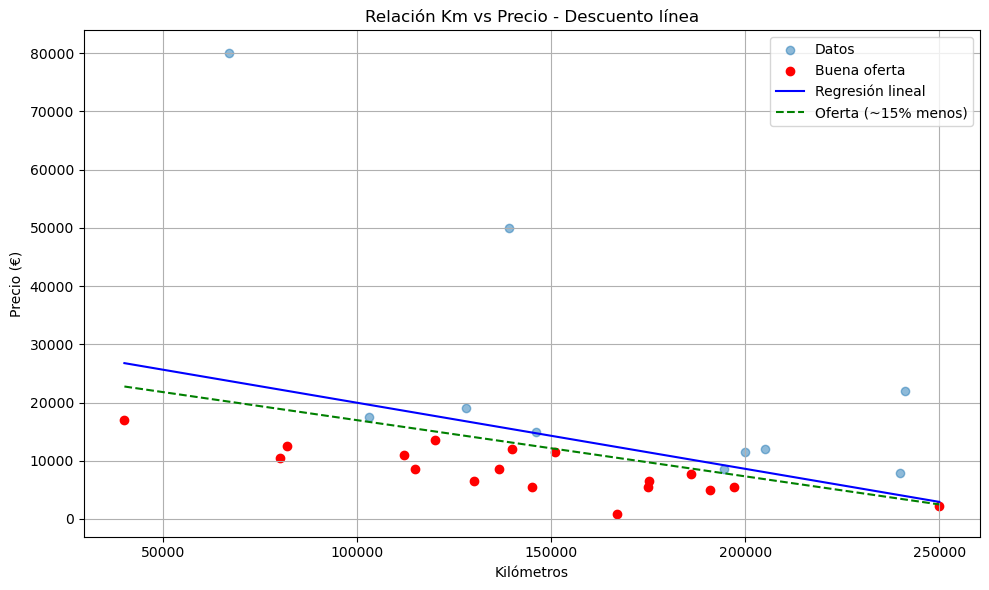

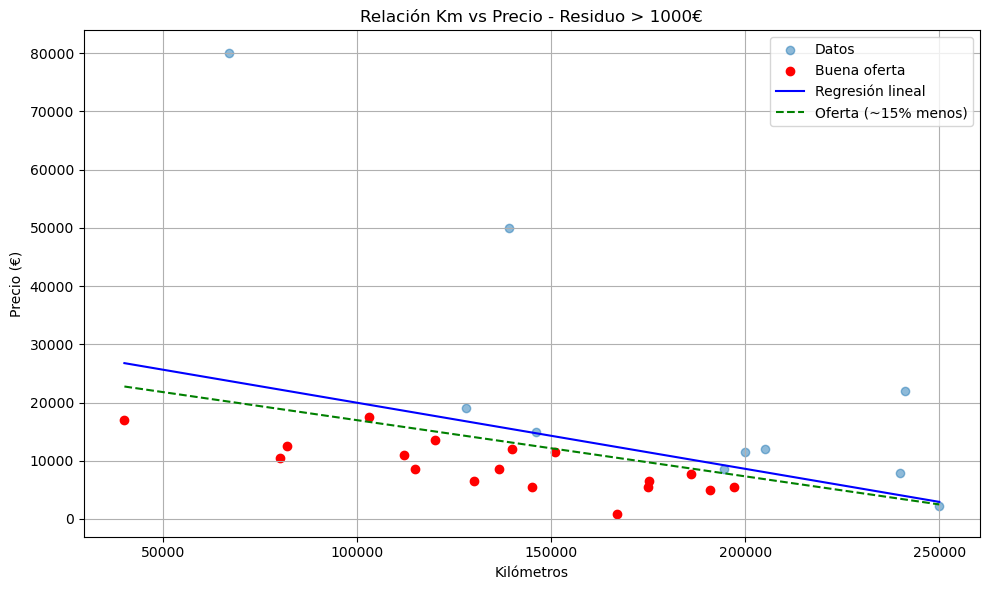

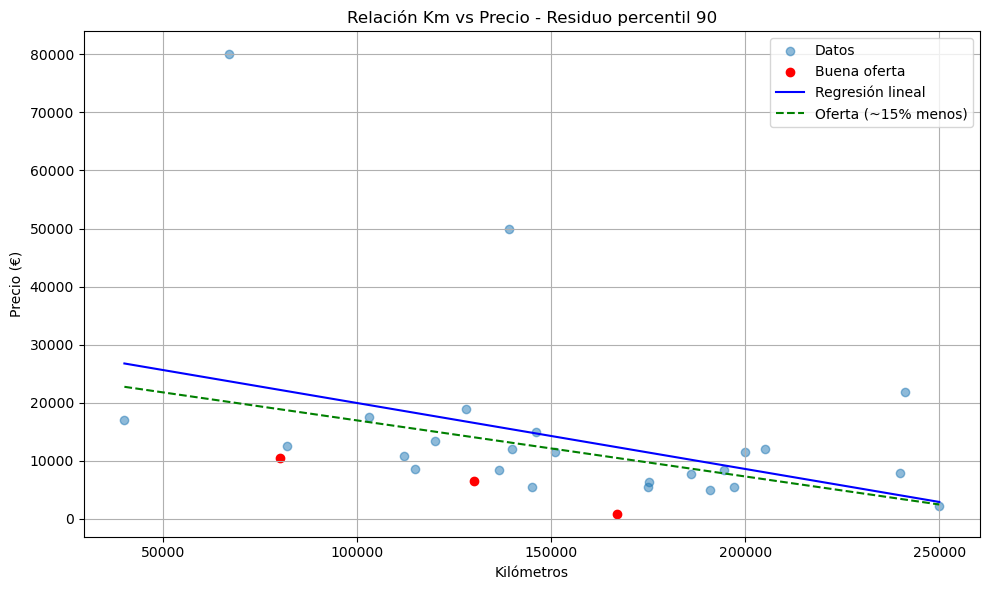

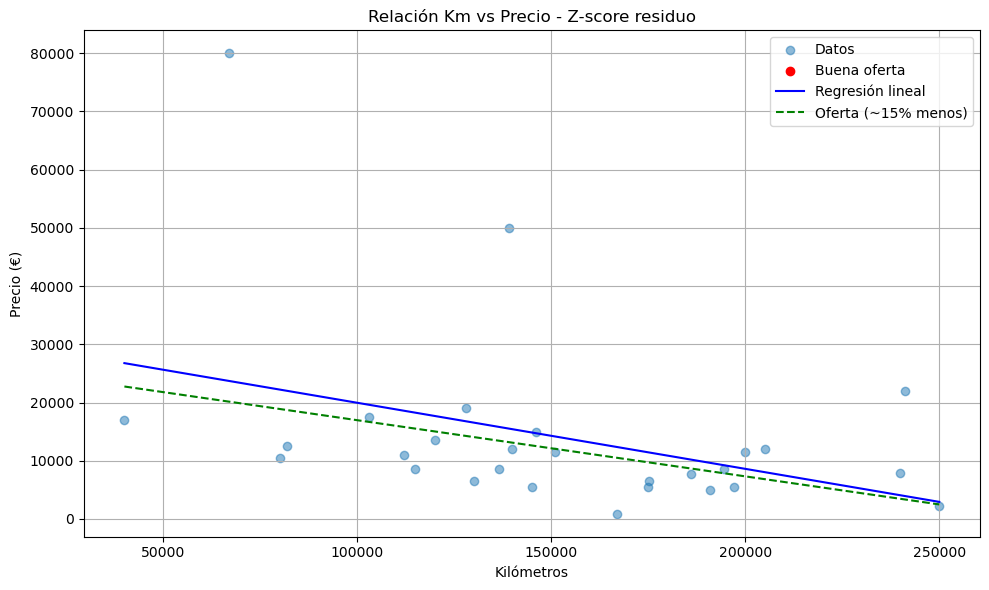

In [ ]:
var = 'kms'  # Cambia esto a 'kms' o 'cv' según lo que quieras analiza
df_filtered, model = regression_data_processing(df_infered, 'No data', var=var)

strategies = {
    'Descuento línea': strategy_discount_line(df_filtered, 0.85),
    'Residuo > 1000€': strategy_residual_threshold(df_filtered, 1000),
    'Residuo percentil 90': strategy_top_percentile_residuals(df_filtered, 90),
    'Z-score residuo': strategy_residual_zscore(df_filtered, 1.5)
}

for name, mask in strategies.items():
    plot_strategy_separately(df_filtered, model, var=var, discount_factor=0.85, strategy_mask=mask, strategy_name=name)



In [ ]:
df_infered['engine'].unique()

array(['2.0', '1.9', '1.8', nan, '2.8', '3.0', '3.2', '2.2'], dtype=object)